<a href="https://colab.research.google.com/github/GaborVxxx/ml_notes/blob/main/NodeMapingTest2_1_0(work).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mimic the headless API that take in the data and make a decision, based only on the provided data.

The while loop is a presentation of a ongoing back and forth call between API and user.

In [412]:
import numpy as np
import pandas as pd
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import spacy
from IPython.display import display
from ipywidgets import interact, widgets, Layout, HBox

nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [413]:
nodes = [
    {
        "name": "R0", "labels":["mixer", "new", "restart", "start", "mixed", "single"], "question": "Is it a mixed or single chart? (R0)"
    },
    {
        "name": "B5", "labels":["gauge", "progress", "progress line"], "question": "Is it a gauge or progress line? Regarding the display? (B5)"
    },
    {
        "name": "B8", "labels":["line", "heat", "pie", "area", "bar"], "question": "Is it a line, heat, pie, area or bar chart? Regarding the display? (B8)"
    },
    {
        "name": "P1", "labels":["user", "team", "company"], "question": "Who is the target? Is it user, team or company? (P1)"
    },
    {
        "name": "P2", "labels":["task", "sale"], "question": "Is it regarding task or sale? (P2)"
    },
    {
        "name": "P3", "labels":["daily", "weekly", "monthly", "yearly", "queterly"], "question": "Is it daily, weekly, monthly, yearly or queterly? (P3)"
    },
    {
        "name": "Y23", "labels":["all", "between", "range"], "question": "Is it all, or from a time range? (Y23)"
    },
    {
        "name": "Y26", "labels":["day", "current", "previous", "week", "month", "year", "quarter"], "question": "Is it day, current, previous, week, month, year or quarter? (Y26)"
    },
    {
        "name": "Y27", "labels":["paid", "pending", "cancelled", "refunded", "partial"], "question": "About the status? Is it paid, pending, cancelled, refunded or partial? (Y27)"
    },
    {
        "name": "Y28", "labels":["avarage", "sum", "min", "max", "count", "total", "minimum", "maximum"], "question": "Is it avarage, sum, min, max, count, total, minimum or maximum? (Y28)"
    },
    {
        "name": "Y29", "labels":["dynamic", "scalling"], "question": "Is it dynamic or scalling? (Y29)"
    },
    {
        "name": "P15", "labels":["organisation", "team", "product", "course", "customer", "source", "user", "opportunity"], "question": "Is it organisation, team, product, course, customer, source, user or opportunity? (P15)"
    },
    {
        "name": "Y24", "labels":["paid", "pending", "cancelled", "refunded", "partial"], "question": "About the status? Is it paid, pending, cancelled, refunded or partial? (Y24)"
    },
    {
        "name": "Y25", "labels":["avarage", "sum", "min", "max", "count", "total", "minimum", "maximum"], "question": "Is it avarage, sum, min, max, count, total, minimum or maximum? (Y25)"
    },
    {
        "name": "P13", "labels":["organisation", "team", "product", "course", "customer", "source", "user", "opportunity"], "question": "Is it organisation, team, product, course, customer, source, user or opportunity? (P13)"
    },

]

In [414]:
node_paths = [
    ["R0", "B5", "P1", "P2", "P3"],
    ["R0", "B8", "Y23", "Y26", "Y27", "Y28",],
    ["R0", "B8", "Y23", "Y26", "Y27", "Y28", "Y29"],
    ["R0", "B8", "Y23", "Y26", "Y27", "Y28", "P15"],
    ["R0", "B8", "Y23", "Y24", "Y25"],
    ["R0", "B8", "Y23", "Y24", "Y25", "P13"]
]

In [415]:
# TODO: lemmatize labels and text too
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if tag is not found

In [416]:
# function to check do we have a path that fully matching any of the paths?
def find_path(all_posible_nodes):
    print(f"All posible nodes in function --->: {all_posible_nodes}")
    if not all_posible_nodes:
        return None

    for path in node_paths:
        # greedy solution... find the first path that has all the element in it from all_posible_nodes
        if all(node in all_posible_nodes for node in path):
            return path

    return None

In [417]:
# next we use Lemmatizer, as an external library to augment the data down to its root words.
class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    words_and_tags = nltk.pos_tag(tokens)
    return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]

In [418]:
# create a tf-idf vectorizer object
tfidf = TfidfVectorizer(
    max_features=3000,
    tokenizer=LemmaTokenizer(),
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 2)
    )

In [419]:
# turn all nodes labels to data matrix
# all_lables_together
all_lables_together = []
for node in nodes:
    labels = node["labels"]
    for label in labels:
        all_lables_together.append(label)

print(list(set(all_lables_together))) # remove duplication
all_unique_lables = list(set(all_lables_together)) # remove

# transform data
X = tfidf.fit_transform(all_unique_lables)

['minimum', 'bar', 'week', 'scalling', 'single', 'restart', 'gauge', 'progress', 'pending', 'heat', 'all', 'queterly', 'total', 'start', 'daily', 'source', 'yearly', 'sum', 'opportunity', 'previous', 'company', 'between', 'refunded', 'paid', 'day', 'min', 'monthly', 'mixed', 'cancelled', 'user', 'course', 'dynamic', 'team', 'year', 'organisation', 'quarter', 'count', 'avarage', 'pie', 'line', 'weekly', 'task', 'month', 'max', 'partial', 'range', 'new', 'area', 'sale', 'current', 'maximum', 'product', 'mixer', 'customer', 'progress line']


In [420]:
TRASHOLD = 0.8

In [421]:
DO_WE_HAVE_A_PATH = None

In [422]:
INITIAL_PROMPT = "Enter any question you like. If the context is related to any topic in model, it will start a path finding process. You can quit by entering 'exit', skip any question with 'skip' command."

In [423]:
ALL_CONCATINATED_TEXT_FROM_USER = ""

In [424]:
ALL_QUESTIONS_IN_CHAT = []

In [425]:
LAST_QUESTION_ASKED = ""

In [426]:
QUESTION_SKIPPED = []

In [427]:
def reset_chat():
    global ALL_CONCATINATED_TEXT_FROM_USER, ALL_QUESTIONS_IN_CHAT, LAST_QUESTION_ASKED, QUESTION_SKIPPED # Declare globals
    ALL_CONCATINATED_TEXT_FROM_USER = ""
    ALL_QUESTIONS_IN_CHAT = []
    LAST_QUESTION_ASKED = ""
    QUESTION_SKIPPED = []

In [428]:
def handle_user_input(user_input):
    global DO_WE_HAVE_A_PATH, ALL_CONCATINATED_TEXT_FROM_USER, ALL_QUESTIONS_IN_CHAT, LAST_QUESTION_ASKED, QUESTION_SKIPPED, questions_to_ask, questuion_to_ask_priority  # Declare globals
    try :

        query = str(user_input)

        # exit the loop any time
        if query.lower().strip() == 'exit':
            reset_chat()
            print("Exiting the program.")
            return

        # reset the loop any time
        if query.lower().strip() == 'reset':
            reset_chat()
            print("Resetting the program.")
            # Instead of just returning, re-display the initial prompt
            display(widgets.HTML(value=f"<b>{INITIAL_PROMPT}</b>"))
            # Create new input widgets and attach the handler again
            text_input = widgets.Text(value="", layout=Layout(width='50%'))
            submit_button = widgets.Button(description="Submit")
            submit_button.on_click(lambda b: handle_user_input(text_input.value))
            display(HBox([text_input, submit_button]))
            return # Exit this call to handle_user_input, new one will start on click

        query = str(user_input) + " " # add extra space!

        ALL_CONCATINATED_TEXT_FROM_USER += query

        # 1. get all the words from the user input query in to one array
        words = []
        for word in ALL_CONCATINATED_TEXT_FROM_USER.split():
            words.append(word)

        # 2. turn the selected_words to data matrix too
        Y = tfidf.transform(words)

        # compute similarity between query and avery vector in X
        scores = cosine_similarity(Y, X)
        #print(scores.shape)
        scores_flat = scores.flatten()

        # visual ploting
        plt.plot(scores_flat)
        plt.xlabel("all node lables")
        plt.ylabel("cosine similarity")

        # scores is an array of probability numbers for each word. I like to have an array of labels that is corespond to any word with higher than 0.8% probability
        # Get the shape of the scores matrix
        num_words, num_labels = scores.shape

        high_score_words = [] # this will be a matrix

        for i in range(num_words):
            is_it_over_trashold = scores[i].sum() > TRASHOLD
            if is_it_over_trashold:
                high_score_words.append(scores[i])

        # now loop over the "high_score_words" and find all the labesl based on the probability array values, where the probablility is higher then the trashold
        high_score_labels = []

        for i in range(len(high_score_words)):
            for j in range(len(high_score_words[i])):
                if high_score_words[i][j] > TRASHOLD:
                    high_score_labels.append(all_unique_lables[j]) # select the label based on the position in array

        print(high_score_labels)

        # from lables -> from there find the right node names for the lable
        all_posible_nodes = []

        for node in nodes:
            labels = node["labels"]
            if any(item in labels for item in high_score_labels):
                all_posible_nodes.append(node["name"])

        print(all_posible_nodes)

        # Do we have a path? If yes return tha path we find.
        DO_WE_HAVE_A_PATH_LOCAL = find_path(all_posible_nodes)
        print(f"In iteration do we have a pathe? {DO_WE_HAVE_A_PATH_LOCAL}")
        if DO_WE_HAVE_A_PATH_LOCAL != None:
            DO_WE_HAVE_A_PATH = DO_WE_HAVE_A_PATH_LOCAL
            print(f"We find a full path: {DO_WE_HAVE_A_PATH}")
            return

        # if all_posible_nodes = [] (AKA no legit node at all) We not start asking random questions...
        if all_posible_nodes == []:
          # return a inputfiled but no question...
            question = "I'm not sure, I can healp you. Try to re-frase it pls."
            display(widgets.HTML(value=f"<b>{question}</b>"))

            # Create text input and button widgets
            text_input = widgets.Text(value="", layout=Layout(width='50%'))
            submit_button = widgets.Button(description="Submit")

            # Define a function to be called when the button is clicked
            def on_submit_clicked(b):
                handle_user_input(text_input.value)  # Pass the text input value

            # Attach the on_click event to the button
            submit_button.on_click(on_submit_clicked)

            # Display the widgets horizontally
            display(HBox([text_input, submit_button]))
            return

        # else start asking questions.
        questions_to_ask = []

        # create a list of potential path the user is talking about based on what we know, only have the top 3 where the most node is maching
        # Calculate matches and sort paths
        sorted_paths = sorted(
            node_paths,
            key=lambda path: len(set(path) & set(all_posible_nodes)),  # Sort by intersection size
            reverse=True  # Largest intersections first
        )

        # Get the top 3 paths
        top_3_paths = sorted_paths[:3]

        # Display the result
        print("Top 3 paths with most matching nodes:")
        for i, path in enumerate(top_3_paths, 1):
            # push the nodes form the matching nodes path to the questions_to_ask, but only the ones we dont already know
            for node in path:
                if node not in all_posible_nodes:
                  if node not in questions_to_ask:
                    if query.lower().strip() == 'skip' and LAST_QUESTION_ASKED == node:
                      # record the skipped question and dont ask them...
                      QUESTION_SKIPPED.append(node)
                      print(f"Skipping question: {node}")
                      continue
                    else:
                        questions_to_ask.append(node)

            print(f"{i}: {path} (Matches: {len(set(path) & set(all_posible_nodes))} / {len(path)})")

        # remove all the node from questions_to_ask that is in QUESTION_SKIPPED
        questions_to_ask = [question for question in questions_to_ask if question not in set(QUESTION_SKIPPED)]

        # assigne the question nodes to global var
        ALL_QUESTIONS_IN_CHAT = questions_to_ask
        LAST_QUESTION_ASKED = questions_to_ask[0] if questions_to_ask else '' # the first in the list always...

        print(f"Skipping list: {set(QUESTION_SKIPPED)}")
        print(f"Last question asked: {LAST_QUESTION_ASKED}")
        print(f"Questions to ask: {questions_to_ask}")

        # prioritize questions form paths that has the highest match number
        questuion_to_ask_priority = []
        for question in questions_to_ask:
            for node in nodes:
                if question == node['name']:
                    questuion_to_ask_priority.append(node['question'])

        # Ask the next question using interact
        if questuion_to_ask_priority:
            question = questuion_to_ask_priority.pop(0)
            display(widgets.HTML(value=f"<b>{question}</b>"))

            # Create text input and button widgets
            text_input = widgets.Text(value="", layout=Layout(width='50%'))
            submit_button = widgets.Button(description="Submit")

            # Define a function to be called when the button is clicked
            def on_submit_clicked(b):
                handle_user_input(text_input.value)  # Pass the text input value

            # Attach the on_click event to the button
            submit_button.on_click(on_submit_clicked)

            # Display the widgets horizontally
            display(HBox([text_input, submit_button]))
        else:
            reset_chat()
            print("No more questions. Path not found.")
            # find the closest metch, based on the info we have...
            top_1_paths = sorted_paths[:1]

            # Display the result
            print("The closest pathe we can find based on input:")
            for i, path in enumerate(top_1_paths , 1):
                # push the nodes form the matching nodes path to the questions_to_ask, but only the ones we dont already know
                print(f"{i}: {path} (Matches: {len(set(path) & set(all_posible_nodes))} / {len(path)})")


    except ValueError as e:
        # Log the actual error message
        print(f"Please enter a valid input. Error: {e}")
        # Optionally, log the full traceback for debugging purposes
        import traceback
        print(traceback.format_exc())

HTML(value="<b>Enter any question you like. If the context is related to any topic in model, it will start a p…

[]
[]
All posible nodes in function --->: []
In iteration do we have a pathe? None


HTML(value="<b>I'm not sure, I can healp you. Try to re-frase it pls.</b>")

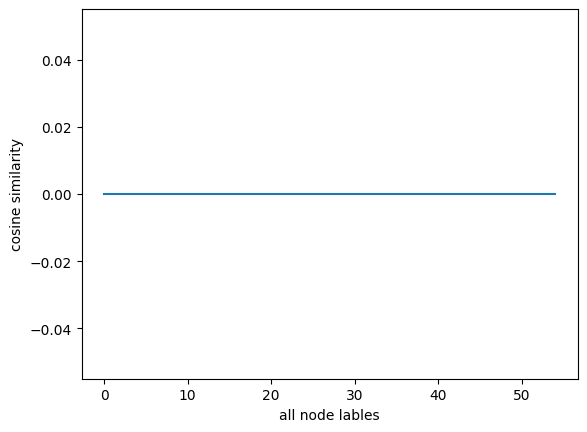

['bar']
['B8']
All posible nodes in function --->: ['B8']
In iteration do we have a pathe? None
Top 3 paths with most matching nodes:
1: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28'] (Matches: 1 / 6)
2: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29'] (Matches: 1 / 7)
3: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'P15'] (Matches: 1 / 7)
Skipping list: set()
Last question asked: R0
Questions to ask: ['R0', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29', 'P15']


HTML(value='<b>Is it a mixed or single chart? (R0)</b>')

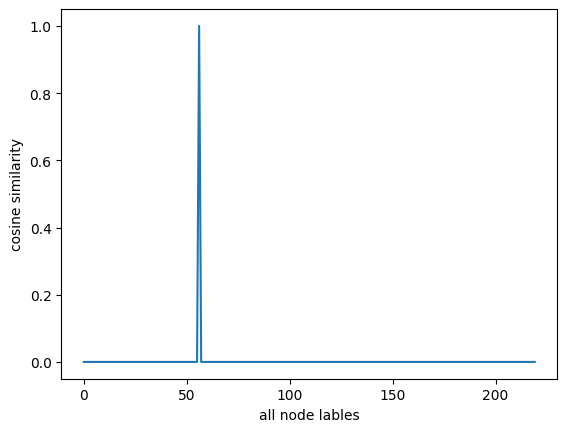

['bar']
['B8']
All posible nodes in function --->: ['B8']
In iteration do we have a pathe? None
Top 3 paths with most matching nodes:
1: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28'] (Matches: 1 / 6)
2: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29'] (Matches: 1 / 7)
3: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'P15'] (Matches: 1 / 7)
Skipping list: set()
Last question asked: R0
Questions to ask: ['R0', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29', 'P15']


HTML(value='<b>Is it a mixed or single chart? (R0)</b>')

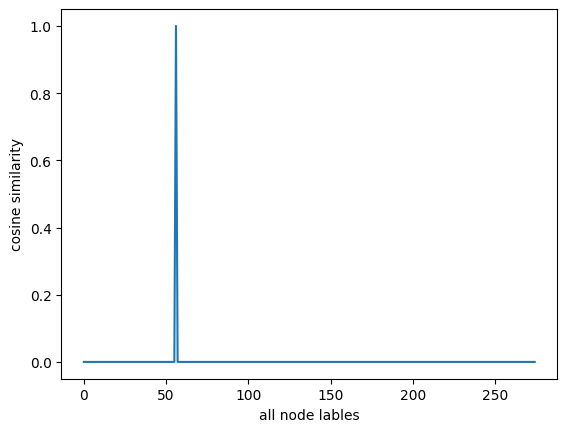

['bar']
['B8']
All posible nodes in function --->: ['B8']
In iteration do we have a pathe? None
Top 3 paths with most matching nodes:
1: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28'] (Matches: 1 / 6)
2: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29'] (Matches: 1 / 7)
3: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'P15'] (Matches: 1 / 7)
Skipping list: set()
Last question asked: R0
Questions to ask: ['R0', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29', 'P15']


HTML(value='<b>Is it a mixed or single chart? (R0)</b>')

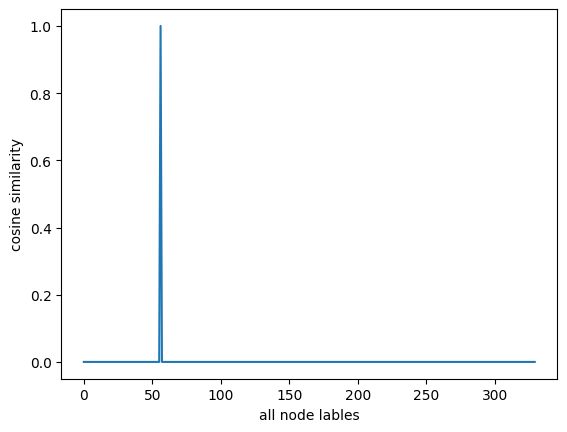

['bar']
['B8']
All posible nodes in function --->: ['B8']
In iteration do we have a pathe? None
Top 3 paths with most matching nodes:
1: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28'] (Matches: 1 / 6)
2: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29'] (Matches: 1 / 7)
3: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'P15'] (Matches: 1 / 7)
Skipping list: set()
Last question asked: R0
Questions to ask: ['R0', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29', 'P15']


HTML(value='<b>Is it a mixed or single chart? (R0)</b>')

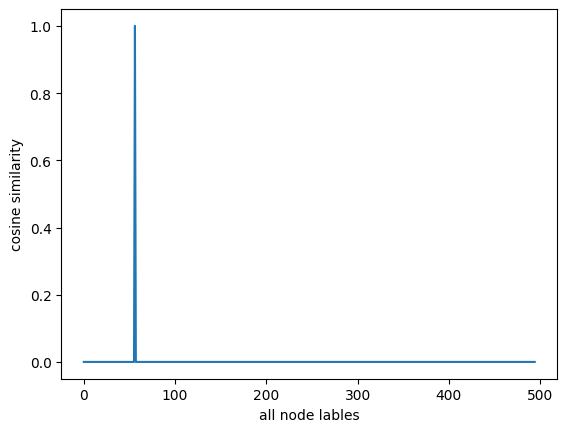

['bar', 'single']
['R0', 'B8']
All posible nodes in function --->: ['R0', 'B8']
In iteration do we have a pathe? None
Top 3 paths with most matching nodes:
1: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28'] (Matches: 2 / 6)
2: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29'] (Matches: 2 / 7)
3: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'P15'] (Matches: 2 / 7)
Skipping list: set()
Last question asked: Y23
Questions to ask: ['Y23', 'Y26', 'Y27', 'Y28', 'Y29', 'P15']


HTML(value='<b>Is it all, or from a time range? (Y23)</b>')

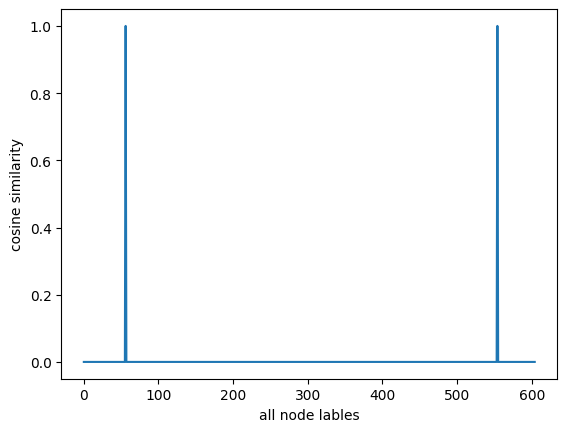

['bar', 'single', 'range']
['R0', 'B8', 'Y23']
All posible nodes in function --->: ['R0', 'B8', 'Y23']
In iteration do we have a pathe? None
Top 3 paths with most matching nodes:
1: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28'] (Matches: 3 / 6)
2: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29'] (Matches: 3 / 7)
3: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'P15'] (Matches: 3 / 7)
Skipping list: set()
Last question asked: Y26
Questions to ask: ['Y26', 'Y27', 'Y28', 'Y29', 'P15']


HTML(value='<b>Is it day, current, previous, week, month, year or quarter? (Y26)</b>')

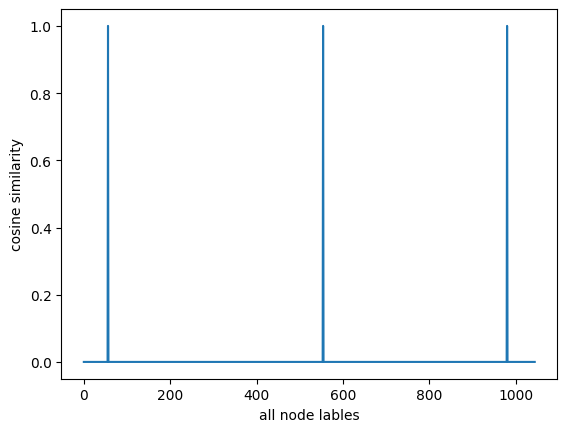

['bar', 'single', 'range', 'weekly']
['R0', 'B8', 'P3', 'Y23']
All posible nodes in function --->: ['R0', 'B8', 'P3', 'Y23']
In iteration do we have a pathe? None
Top 3 paths with most matching nodes:
1: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28'] (Matches: 3 / 6)
2: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29'] (Matches: 3 / 7)
3: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'P15'] (Matches: 3 / 7)
Skipping list: set()
Last question asked: Y26
Questions to ask: ['Y26', 'Y27', 'Y28', 'Y29', 'P15']


HTML(value='<b>Is it day, current, previous, week, month, year or quarter? (Y26)</b>')

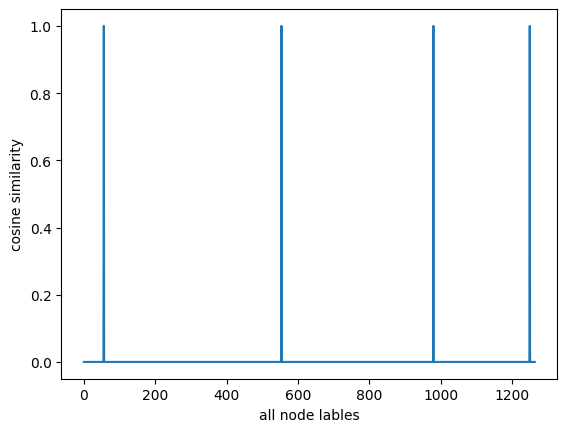

['bar', 'single', 'range', 'weekly', 'week']
['R0', 'B8', 'P3', 'Y23', 'Y26']
All posible nodes in function --->: ['R0', 'B8', 'P3', 'Y23', 'Y26']
In iteration do we have a pathe? None
Top 3 paths with most matching nodes:
1: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28'] (Matches: 4 / 6)
2: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29'] (Matches: 4 / 7)
3: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'P15'] (Matches: 4 / 7)
Skipping list: set()
Last question asked: Y27
Questions to ask: ['Y27', 'Y28', 'Y29', 'P15']


HTML(value='<b>About the status? Is it paid, pending, cancelled, refunded or partial? (Y27)</b>')

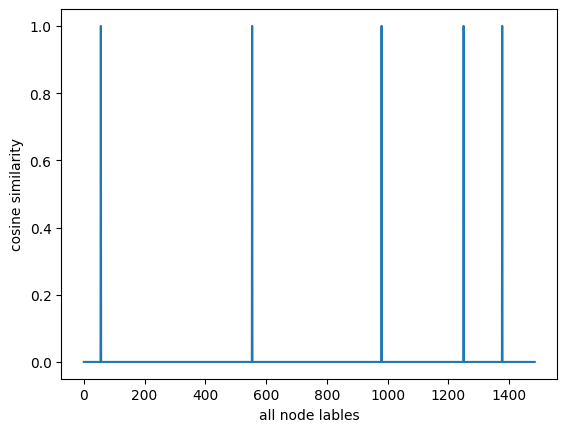

['bar', 'single', 'range', 'weekly', 'week', 'paid']
['R0', 'B8', 'P3', 'Y23', 'Y26', 'Y27', 'Y24']
All posible nodes in function --->: ['R0', 'B8', 'P3', 'Y23', 'Y26', 'Y27', 'Y24']
In iteration do we have a pathe? None
Top 3 paths with most matching nodes:
1: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28'] (Matches: 5 / 6)
2: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'Y29'] (Matches: 5 / 7)
3: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28', 'P15'] (Matches: 5 / 7)
Skipping list: set()
Last question asked: Y28
Questions to ask: ['Y28', 'Y29', 'P15']


HTML(value='<b>Is it avarage, sum, min, max, count, total, minimum or maximum? (Y28)</b>')

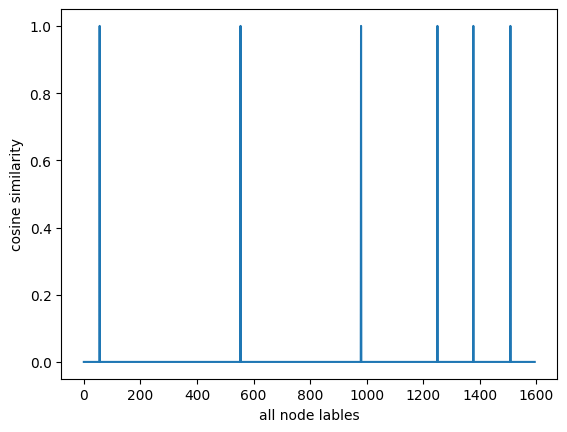

['bar', 'single', 'range', 'weekly', 'week', 'paid', 'avarage']
['R0', 'B8', 'P3', 'Y23', 'Y26', 'Y27', 'Y28', 'Y24', 'Y25']
All posible nodes in function --->: ['R0', 'B8', 'P3', 'Y23', 'Y26', 'Y27', 'Y28', 'Y24', 'Y25']
In iteration do we have a pathe? ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28']
We find a full path: ['R0', 'B8', 'Y23', 'Y26', 'Y27', 'Y28']


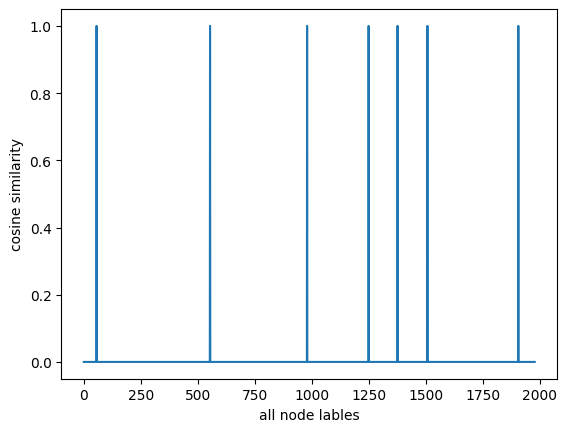

In [429]:
# Start the interaction
if DO_WE_HAVE_A_PATH is None:
    display(widgets.HTML(value=f"<b>{INITIAL_PROMPT}</b>"))
    # Use interactive to create the initial input and button
    text_input = widgets.Text(value="", layout=Layout(width='50%'))
    submit_button = widgets.Button(description="Submit")
    submit_button.on_click(lambda b: handle_user_input(text_input.value))
    display(HBox([text_input, submit_button]))
else:
    print(f"Path found initially: {DO_WE_HAVE_A_PATH}")